In [1]:
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import inference_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np
import pickle

import fiftyone as fo
from PIL import Image
from torchvision.transforms import functional as func
from mmdet.apis import inference_detector, show_result_pyplot
from PIL import Image
from torchvision.transforms import functional as func

In [2]:
MODEL = 'centernet2.py'
PATH = '../work_dirs/no-rigid-aug_centernet2_cascade_res50_fpn_1x_coco'
EPOCH ='best_bbox_mAP_50_epoch_39.pth'

cfg =Config.fromfile(os.path.join(PATH,MODEL))
cfg.data.test.test_mode = True

# build dataset & dataloader
test_dataset = build_dataset(cfg.data.val)
test_loader = build_dataloader(
        test_dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

checkpoint_path = os.path.join(PATH,EPOCH)

# build detector
model = build_detector(cfg.model) 

# ckpt load
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu') 

model.CLASSES = test_dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Use load_from_local loader


In [3]:
# output 계산
output = single_gpu_test(model, test_loader, show_score_thr=0)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 966/966, 2.7 task/s, elapsed: 362s, ETA:     0s

In [4]:
dataset = fo.Dataset.from_dir(
    data_path = '/opt/ml/detection/dataset',
    dataset_type= fo.types.COCODetectionDataset,
    labels_path='/opt/ml/detection/dataset/kfold/cv_val1.json')

 100% |█████████████████| 966/966 [3.9s elapsed, 0s remaining, 258.6 samples/s]      



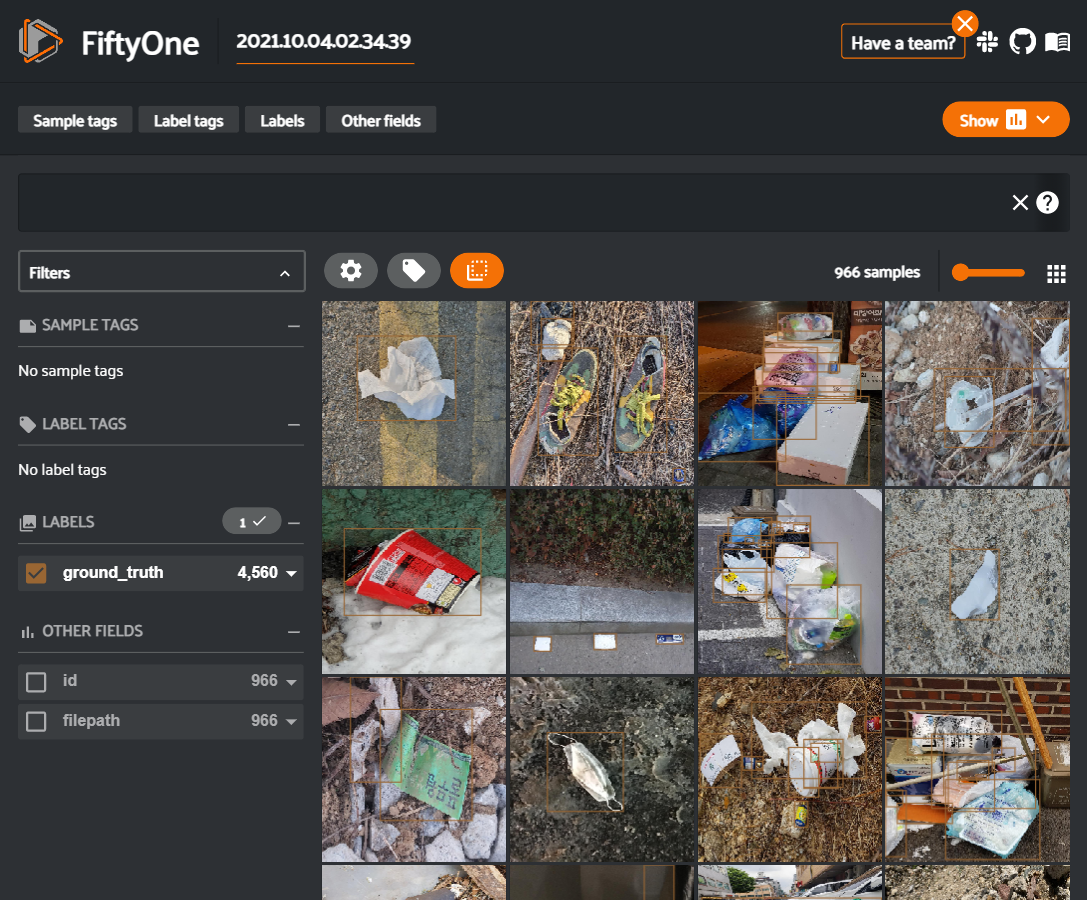

In [5]:
session = fo.launch_app(dataset)

In [6]:
predictions_view = dataset.limit(len(dataset))

# Add predictions to samples
with fo.ProgressBar() as pb:
    for idx,sample in enumerate(pb(predictions_view)):
        c, h, w = 3,1024,1024

        #result = inference_detector(model, sample.filepath)
        #show_result_pyplot(model, sample.filepath, result)
        result = output[idx]
        labels=[]
        scores=[]
        boxes=[]
        for label,values in enumerate(result):
            for pred in values:
                labels.append(label)
                scores.append(pred[-1])
                boxes.append(list(pred[0:4]))

        # Convert detections to FiftyOne format
        detections = []
        for label, score, box in zip(labels, scores, boxes):
            # Convert to [top-left-x, top-left-y, width, height]
            # in relative coordinates in [0, 1] x [0, 1]
            x1, y1, x2, y2 = box
            rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]

            detections.append(
                fo.Detection(
                    label=model.module.CLASSES[label],
                    bounding_box=rel_box,
                    confidence=score
                )
            )

        # Save predictions to dataset
        sample["predictions"] = fo.Detections(detections=detections)
        sample.save()

 100% |█████████████████| 966/966 [11.6s elapsed, 0s remaining, 92.3 samples/s]      


In [7]:
session.view = predictions_view
session.freeze()

## Mistakeness

In [8]:
import fiftyone.brain as fob
from fiftyone import ViewField as F

In [9]:
fob.compute_mistakenness(dataset, "predictions", label_field="ground_truth")

Evaluating detections...
 100% |█████████████████| 966/966 [24.9s elapsed, 0s remaining, 46.4 samples/s]      
Computing mistakenness...
 100% |█████████████████| 966/966 [20.1s elapsed, 0s remaining, 55.7 samples/s]      
Mistakenness computation complete



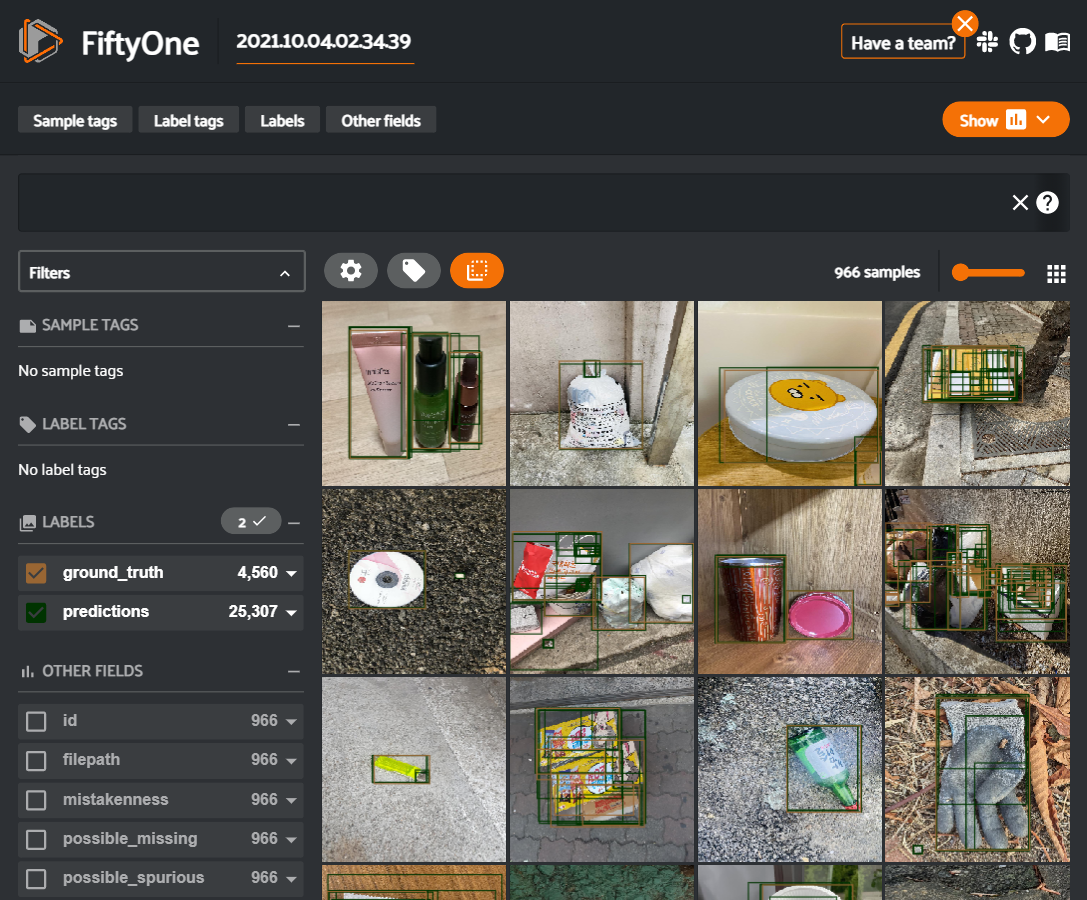

In [10]:


# Sort by likelihood of mistake (most likely first)
mistake_view = dataset.sort_by("mistakenness", reverse=True)
session.view = mistake_view

## FP, TP ...
- Confidence가 높으면서 FP인 것은 miss-label을 의심하거나 모델이 잘 못 예측하는 것의 특징을 파악하는 데에 도움!!

In [11]:
results = dataset.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
    method="coco",
    eval_key="eval",
)

Evaluating detections...
 100% |█████████████████| 966/966 [23.7s elapsed, 0s remaining, 50.8 samples/s]      



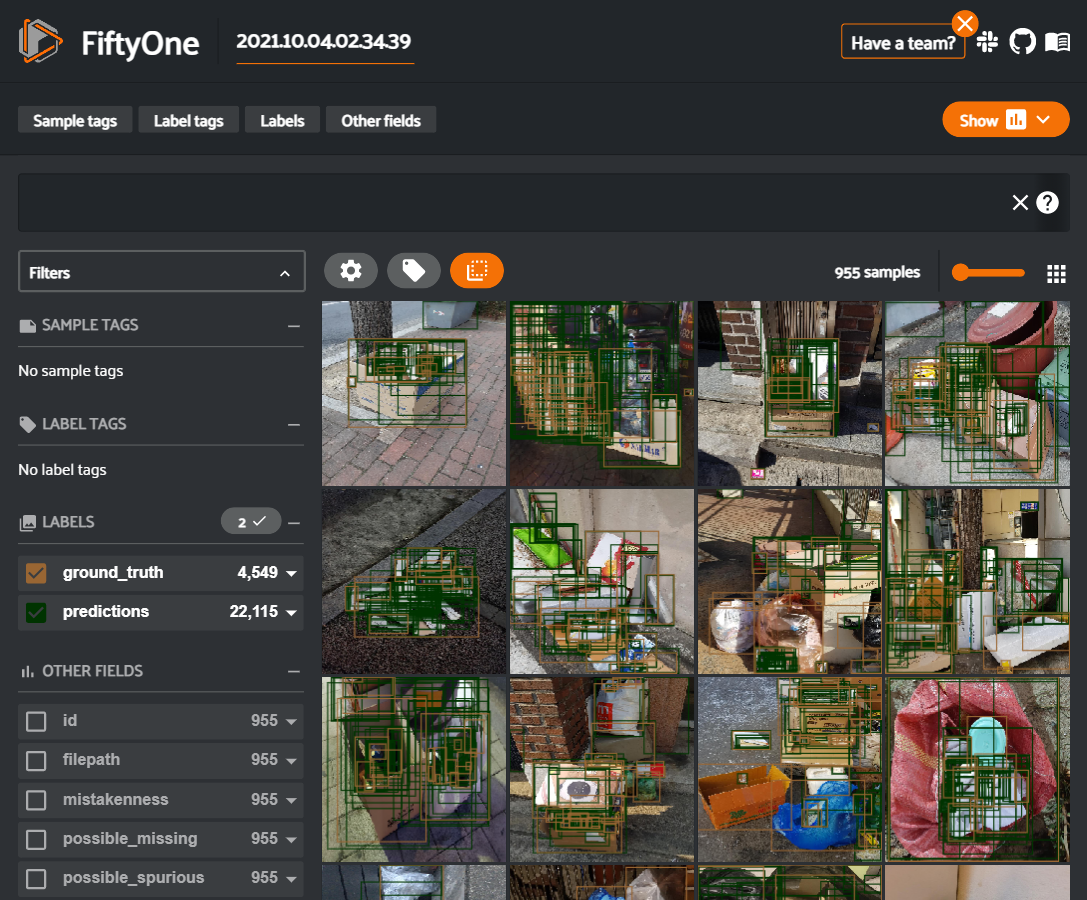

In [12]:
view = (
    dataset
    .sort_by("eval_fp", reverse=True)
    .filter_labels("predictions", F("eval") == "fp")
)

# Visualize results in the App
session = fo.launch_app(view=view)

In [13]:
# Get the 10 most common classes in the dataset
counts = dataset.count_values("ground_truth.detections.label")
classes = sorted(counts, key=counts.get, reverse=True)

# Print a classification report for the top-10 classes
results.print_report(classes=classes)

# Print some statistics about the total TP/FP/FN counts
print("TP: %d" % dataset.sum("eval_tp"))
print("FP: %d" % dataset.sum("eval_fp"))
print("FN: %d" % dataset.sum("eval_fn"))

               precision    recall  f1-score   support

        Paper       0.11      0.75      0.20      1363
  Plastic bag       0.20      0.79      0.32       996
General trash       0.08      0.59      0.14       761
      Plastic       0.11      0.64      0.19       582
    Styrofoam       0.16      0.57      0.24       253
        Metal       0.17      0.71      0.27       168
        Glass       0.13      0.65      0.22       164
   Paper pack       0.19      0.75      0.31       162
     Clothing       0.10      0.68      0.18        74
      Battery       0.25      0.70      0.37        37

    micro avg       0.13      0.70      0.21      4560
    macro avg       0.15      0.68      0.25      4560
 weighted avg       0.14      0.70      0.23      4560

TP: 3192
FP: 22115
FN: 1368
